In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Face_Mask_Detection_Dataset_Kaggle"

In [ ]:
%cd /content/drive/MyDrive/Face_Mask_Detection_Dataset_Kaggle

/content/drive/MyDrive/Face_Mask_Detection_Dataset_Kaggle


In [ ]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

100% 329M/330M [00:04<00:00, 81.8MB/s]
100% 330M/330M [00:04<00:00, 70.3MB/s]


In [ ]:
%ls

face-mask-12k-images-dataset.zip  kaggle.json


In [ ]:
%cd /content

/content


In [ ]:
# !unzip /content/drive/MyDrive/Face_Mask_Detection_Dataset_Kaggle/face-mask-12k-images-dataset.zip

In [ ]:
# improt the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
import cv2
import os
from glob import glob 
import seaborn as sns
from tabulate import tabulate
import random 
import cv2
import os

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Load train and test set
train_dir = '/content/Face Mask Dataset/Train'
test_dir = '/content/Face Mask Dataset/Test'
val_dir = '/content/Face Mask Dataset/Validation'

In [ ]:
# Map the images from train folder with train labels to form a DataFrame
def get_all_images_from_subdirectory_to_dataframe(path):
  configfiles = [os.path.join(dirpath, f)
      for dirpath, dirnames, files in os.walk(path)
      for f in files if f.endswith('.png')]
  images_list = [(i.split("/")[-2],i.split("/")[-1], i) for i in configfiles]
  return images_list

In [ ]:
df_list = get_all_images_from_subdirectory_to_dataframe(train_dir)
df_train = pd.DataFrame(data=df_list, columns=['class', 'image_name', 'image_path'])

df_list = get_all_images_from_subdirectory_to_dataframe(test_dir)
df_test = pd.DataFrame(data=df_list, columns=['class', 'image_name', 'image_path'])

df_list = get_all_images_from_subdirectory_to_dataframe(val_dir)
df_val = pd.DataFrame(data=df_list, columns=['class', 'image_name', 'image_path'])

In [ ]:
df_train.head(2)

,class,image_name,image_path
0,WithoutMask,2083.png,/content/Face Mask Dataset/Train/WithoutMask/2...
1,WithoutMask,4529.png,/content/Face Mask Dataset/Train/WithoutMask/4...


In [ ]:
df_test.head(2)

,class,image_name,image_path
0,WithoutMask,2483.png,/content/Face Mask Dataset/Test/WithoutMask/24...
1,WithoutMask,5662.png,/content/Face Mask Dataset/Test/WithoutMask/56...


In [ ]:
df_val.head(2)

,class,image_name,image_path
0,WithoutMask,1162.png,/content/Face Mask Dataset/Validation/WithoutM...
1,WithoutMask,5927.png,/content/Face Mask Dataset/Validation/WithoutM...


In [ ]:
# Write a function that will select n random images and display images along with its species
def plot_random_images(df, total_image=2):
    import matplotlib.image as mpimg
    fig, axes = plt.subplots(1, total_image,figsize=(14,2))
    images_data = list(zip(df['image_path'],df['class']))
    samples = random.sample(images_data,total_image)
    for ax, (image, label) in zip(axes, samples):
        image = mpimg.imread(image)
        ax.set_axis_off()
        ax.imshow(image, cmap = 'binary')
        ax.set_title(f'{label}')

Traning Images


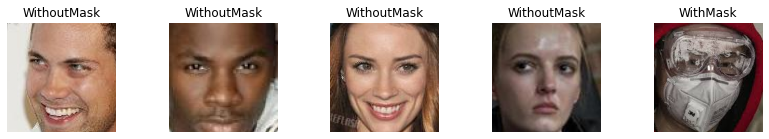

In [ ]:
print("Traning Images")
plot_random_images(df_train, 5)

Testing Images


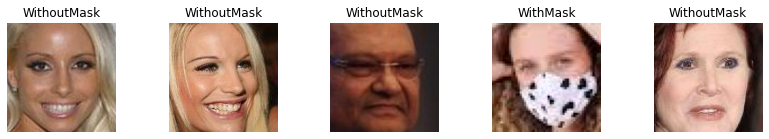

In [ ]:
print("Testing Images")
plot_random_images(df_test, 5)

Validation Images


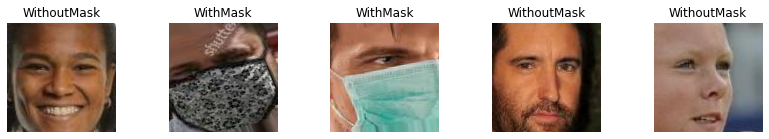

In [ ]:
print("Validation Images")
plot_random_images(df_val, 5)

In [ ]:
def categroy_distribution(data, col, top=None):
    print("\t\t{} Distribution".format(col))
    print()
    perc = round(data[col].value_counts(normalize=True)[:top]*100,2)

    dataCat = perc.to_frame().reset_index().rename(columns={'index':'Category',
                                                          col:f'{col}Percentage'})
    print(tabulate(dataCat, headers = 'keys', tablefmt = 'psql'))
    plt.figure(figsize=(7,7))
    fig = sns.countplot(x=col, data=data, color="g", order=data[col].value_counts().iloc[:top].index)
    for p in fig.patches:
        fig.annotate(f'\n{p.get_height()}', (p.get_x(), p.get_height()+10), size=15)
    plt.xticks(rotation=90)
    plt.show()

training distribution

		class Distribution

+----+-------------+-------------------+
|    | Category    |   classPercentage |
|----+-------------+-------------------|
|  0 | WithoutMask |                50 |
|  1 | WithMask    |                50 |
+----+-------------+-------------------+


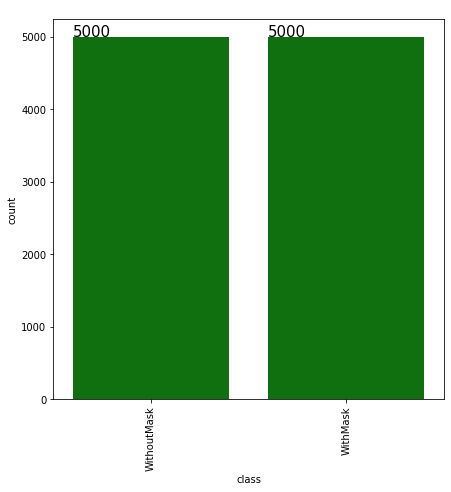

In [ ]:
print("training distribution\n")
categroy_distribution(df_train,'class')

testing distribution
		class Distribution

+----+-------------+-------------------+
|    | Category    |   classPercentage |
|----+-------------+-------------------|
|  0 | WithoutMask |             51.31 |
|  1 | WithMask    |             48.69 |
+----+-------------+-------------------+


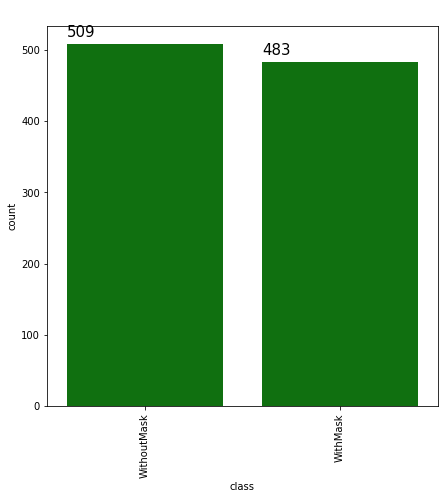

In [ ]:
print("testing distribution")
categroy_distribution(df_test,'class')

validation distribution
		class Distribution

+----+-------------+-------------------+
|    | Category    |   classPercentage |
|----+-------------+-------------------|
|  0 | WithoutMask |                50 |
|  1 | WithMask    |                50 |
+----+-------------+-------------------+


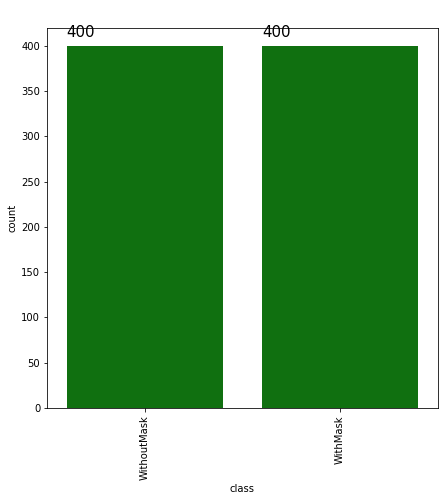

In [ ]:
print("validation distribution")
categroy_distribution(df_val,'class')

# **Model Building**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from termcolor import colored
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import clear_output
import time
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix
import seaborn as sns
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16

from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator


In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator( horizontal_flip=True,
                                   shear_range=0.2,
                                  rescale= 1./255,
                                  zoom_range=0.2,)

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224,224),
        batch_size=32,
        shuffle = False,
        seed = 42,
         class_mode = "categorical",
        classes = ['WithoutMask','WithMask'])

test_set = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224,224),
        seed = 42,
        shuffle = False,
        batch_size=32,
        class_mode = "categorical",
        classes = ['WithoutMask','WithMask'])

val_set = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224,224),
        seed = 42,
        shuffle = False,
        batch_size=32,
        class_mode = "categorical",
        classes = ['WithoutMask','WithMask'])

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [ ]:
val_set.class_indices

{'WithoutMask': 0, 'WithMask': 1}

In [ ]:
# function for evaluation metrics precision, recall, f1 etc
def modelEvaluation(predictions, y_test_set):
    # Print model evaluation to predicted result    
    start_time = time.time()
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test_set, predictions)))
    print ("\nClassification report : \n", classification_report(y_test_set, predictions))
    print ("\nConfusion Matrix : \n", confusion_matrix(y_test_set, predictions))
    cm = confusion_matrix(y_test_set, predictions)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    end = round(time.time()-start_time,3)
    results = [accuracy_score(y_test_set, predictions),precision_score(y_test_set, predictions),
              recall_score(y_test_set, predictions),f1_score(y_test_set, predictions)]
    return results

In [ ]:
def plot_acc_loss(result, epochs):
    acc = result.history['accuracy']
    loss = result.history['loss']
    val_acc = result.history['val_accuracy']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_accuracy')
    plt.plot(range(1,epochs), val_acc[1:], label='Val_accuracy')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Val_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def build_pretrained_model(model_object,nb_epochs=10):
  # re-size all the images to this
  IMAGE_SIZE = [224, 224]
  # add preprocessing layer
  pretrained_model = model_object(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

  # don't train existing weights
  for layer in pretrained_model.layers:
    layer.trainable = False

  model = Sequential()
  model.add(pretrained_model)
  model.add(Flatten())
  model.add(Dense(2,activation='softmax'))


  # view the structure of the model
  model.summary()

  # model compile
  model.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  
  # fit the model
  history = model.fit(train_set,
                                validation_data=val_set,
                                epochs=nb_epochs,
                                verbose=1)
  
  # plotting the graph
  plot_acc_loss(history, nb_epochs)

  test_pred = model.predict(test_set)
  test_pred = np.argmax(test_pred,axis = 1)
  test_labels = test_set.labels
  return test_labels,test_pred, model

# **Pretrained Model - VGG16**

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 25088)             0         
                                                                 
 dense_12 (Dense)            (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/20
313/313 [==============================] - 110s 349ms/step - loss: 0.1552 - accuracy: 0.9480 - val_loss: 0.0246 - val_accuracy: 0.9912
Epoch 2/20
313/313 [==============================] - 109s 347ms/step - loss: 0.0289 - accuracy: 0.9890 - val_loss: 0.0228 - val_accuracy: 0.9900
Epoch 3/2

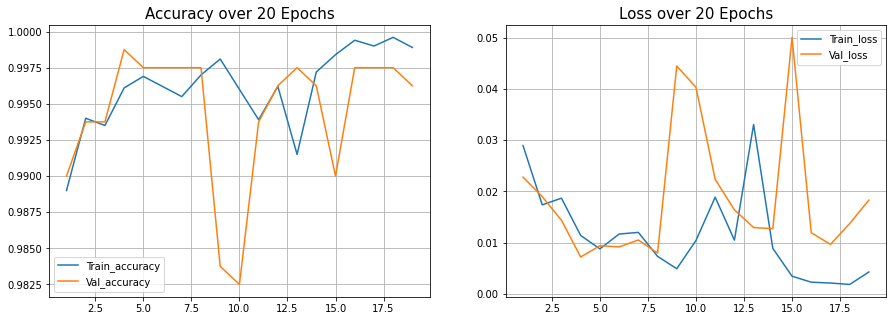

31/31 [==============================] - 2s 60ms/step

Accuracy on validation set: 0.9970

Classification report : 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       506
           1       1.00      0.99      1.00       486

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992


Confusion Matrix : 
 [[506   0]
 [  3 483]]


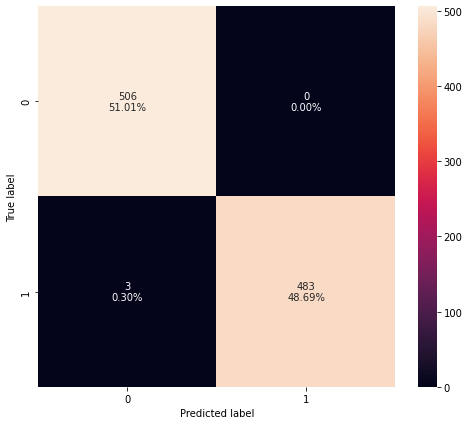

In [ ]:
y_test_vgg16,y_pred_vgg16, modelVGG16 = build_pretrained_model(VGG16,nb_epochs=20)
results_vgg16 = modelEvaluation(y_test_vgg16,y_pred_vgg16)

# **Pretrained Model - MobileNet**

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_10 (Flatten)        (None, 62720)             0         
                                                                 
 dense_13 (Dense)            (None, 2)                 125442    
                                                                 
Total params: 2,383,426
Trainable params: 125,442
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/20
313/313 [==============================] - 113s 352ms/step - loss: 0.7256 - accuracy: 0.9695 - val_loss: 0.1449 - val_accuracy: 0.9875
Epoch 2/20
313/313 [==============================] - 109s 349ms/step - loss: 0.1597 - ac

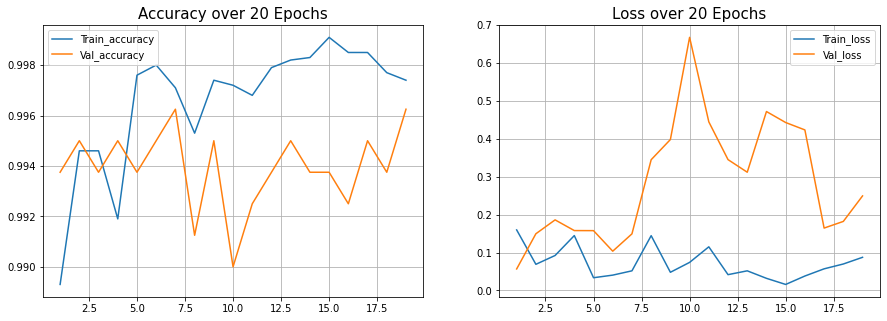

31/31 [==============================] - 3s 62ms/step

Accuracy on validation set: 0.9980

Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       509
           1       1.00      1.00      1.00       483

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992


Confusion Matrix : 
 [[508   1]
 [  1 482]]


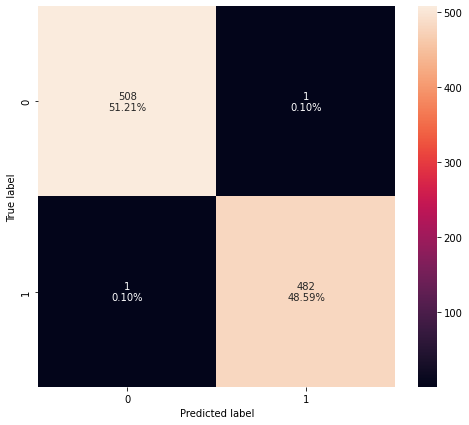

In [ ]:
y_test_mobilenet,y_pred_mobilenet, modelMobileNet = build_pretrained_model(MobileNetV2,nb_epochs=20)
results_mobilenet = modelEvaluation(y_test_mobilenet,y_pred_mobilenet)

# **Pretrained Model - VGG19**

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_11 (Flatten)        (None, 25088)             0         
                                                                 
 dense_14 (Dense)            (None, 2)                 50178     
                                                                 
Total params: 20,074,562
Trainable params: 50,178
Non-trainable params: 20,024,384
_________________________________________________________________
Epoch 1/20
313/313 [==============================] - 110s 350ms/step - loss: 0.3132 - accuracy: 0.9154 - val_loss: 0.0356 - val_accuracy: 0.9850
Epoch 2/20
313/313 [==============================] - 109s 348ms/step - loss: 0.0455 - accuracy: 0.9844 - val_loss: 0.0247 - val_accuracy: 0.9912
Epoch 3/

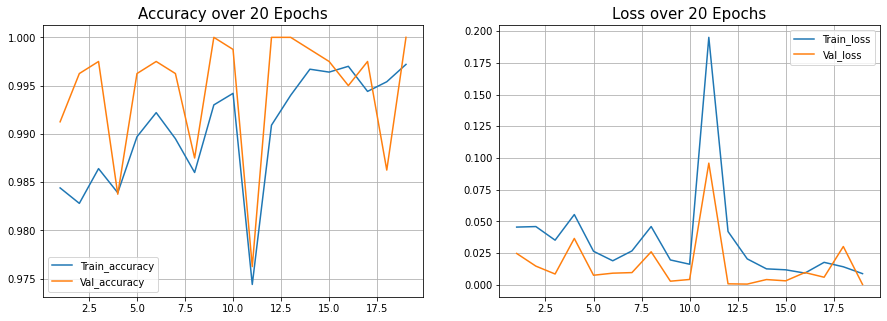

31/31 [==============================] - 2s 61ms/step

Accuracy on validation set: 0.9970

Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       508
           1       1.00      1.00      1.00       484

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992


Confusion Matrix : 
 [[507   1]
 [  2 482]]


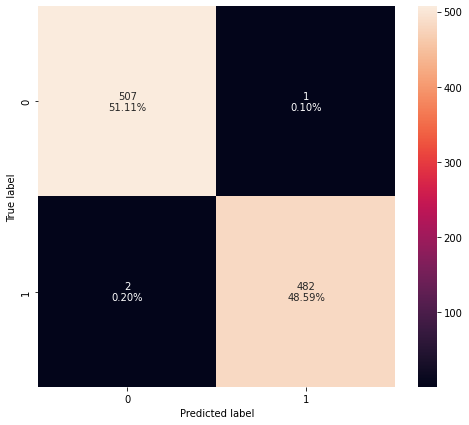

In [ ]:
y_test_vgg19,y_pred_vgg19, modelVGG19 = build_pretrained_model(VGG19,nb_epochs=20)
results_vgg19 = modelEvaluation(y_test_vgg19,y_pred_vgg19)

# **Models Evaluation**

In [ ]:
# showing all models result
dic = {
    'Metrics':['accuracy','precision','recall','f1-score'],
    'VGG16' : results_vgg16,
    'MobileNet' : results_mobilenet,
    'VGG19' : results_vgg19,    

}
metrics_df = pd.DataFrame(dic)

metrics_df = metrics_df.set_index('Metrics')
# displaying the DataFrame
print(tabulate(metrics_df.T, headers = 'keys', tablefmt = 'psql'))

+-----------+------------+-------------+----------+------------+
|           |   accuracy |   precision |   recall |   f1-score |
|-----------+------------+-------------+----------+------------|
| VGG16     |   0.996976 |     1       | 0.993827 |   0.996904 |
| MobileNet |   0.997984 |     0.99793 | 0.99793  |   0.99793  |
| VGG19     |   0.996976 |     0.99793 | 0.995868 |   0.996898 |
+-----------+------------+-------------+----------+------------+


**From above table, we can see that all models giving good results. Therefore, we will choose the low weight model that is MobileNet.**

# **Save Model**

In [ ]:
# serialize model to JSON
from keras.models import model_from_json
model_json = modelMobileNet.to_json()
with open("/content/drive/MyDrive/Face_Mask_Detection_Dataset_Kaggle/face_mask_detection_model_file_MobileNet.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
modelMobileNet.save_weights("/content/drive/MyDrive/Face_Mask_Detection_Dataset_Kaggle/face_mask_detection_model_file_MobileNet.h5")
print("Saved model to disk")
 

Saved model to disk


# **Load Model**

In [ ]:
# load json and create model
from keras.models import model_from_json
json_file = open('/content/drive/MyDrive/Face_Mask_Detection_Dataset_Kaggle/face_mask_detection_model_file_MobileNet.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Face_Mask_Detection_Dataset_Kaggle/face_mask_detection_model_file_MobileNet.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
def image_prediction(path):
    mask_label = {0:'NO MASK',1:'MASK'}
    sample_mask_img = cv2.imread(path)
    img = cv2.resize(sample_mask_img,(224,224))
    sample_mask_img = np.reshape(img,[1,224,224,3])
    sample_mask_img = sample_mask_img/255.0
    label = np.argmax(loaded_model.predict(sample_mask_img, verbose=0))
    plt.imshow(img)
    plt.title(mask_label[label], fontsize=15)
    plt.show()

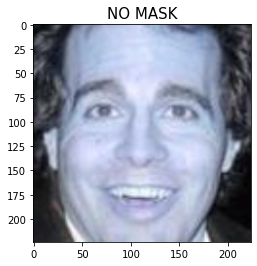

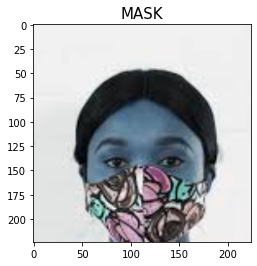

In [ ]:
image_prediction("/content/Face Mask Dataset/Test/WithoutMask/1015.png")
image_prediction("/content/Face Mask Dataset/Test/WithMask/1404.png")

In [ ]:
# !git clone "https://github.com/kipr/opencv.git"

In [ ]:
cascPath = "/content/opencv/data/haarcascades/haarcascade_frontalface_default.xml"

In [ ]:
# !cp -r "/content/opencv/data/haarcascades/haarcascade_frontalface_default.xml" "/content/drive/MyDrive/Face_Mask_Detection_Dataset_Kaggle"

In [ ]:
#loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier('/content/drive/MyDrive/Face_Mask_Detection_Dataset_Kaggle/haarcascade_frontalface_default.xml')
face_model

< cv2.CascadeClassifier 0x7f93d6107710>

In [ ]:
def draw_reactangle_on_image_prediction(img):
  #trying it out on a sample image
  img = cv2.imread(img)

  img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

  faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

  out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

  mask_label = {1:'MASK',0:'NO MASK'}
  dist_label = {0:(0,255,0),1:(255,0,0)}

  MIN_DISTANCE = 130
  label = [0 for i in range(len(faces))]
  for i in range(len(faces)-1):
      for j in range(i+1, len(faces)):
          dist = distance.euclidean(faces[i][:2],faces[j][:2])
          if dist<MIN_DISTANCE:
              label[i] = 1
              label[j] = 1
  new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
  for i in range(len(faces)):
      (x,y,w,h) = faces[i]
      crop = new_img[y:y+h,x:x+w]
      crop = cv2.resize(crop,(224,224))
      crop = np.reshape(crop,[1,224,224,3])/255.0
      mask_result = loaded_model.predict(crop)
      idx = mask_result.argmax()
      prob = round(mask_result[:,idx][0]*100,2)
      cv2.putText(new_img,str(mask_label[idx])+": "+str(prob)+"%",(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)

      cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
  plt.figure(figsize=(10,10))
  plt.imshow(new_img)

1/1 [==============================] - 0s 21ms/step


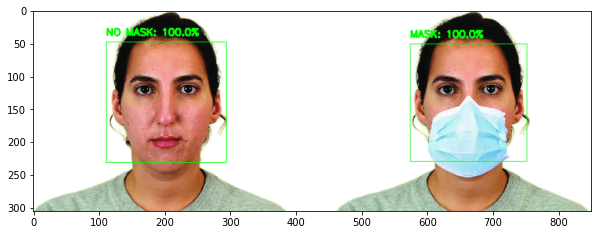

In [ ]:
draw_reactangle_on_image_prediction("/content/testing_image.png")

1/1 [==============================] - 0s 21ms/step


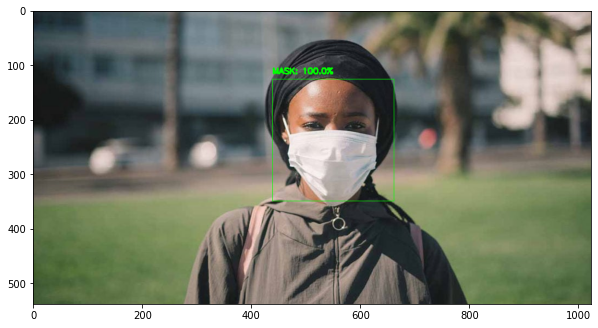

In [ ]:
draw_reactangle_on_image_prediction("/content/face-mask-woman-1024x538.jpg")